In [0]:
# import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')



In [0]:
import os
import pandas as pd


current_path = os.getcwd()  
target_path = os.path.abspath(os.path.join(
    current_path,
    "../../../data/customer_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv"
))

# import our data from csv file
df = pd.read_csv(target_path)

# show two rows
df.head(2)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Let's first clarify the variables of our dataset:

customerID – Unique identifier for each customer.

gender – Customer’s gender (e.g., Male/Female).

SeniorCitizen – Indicates if the customer is a senior (1 = Yes, 0 = No).

Partner – Whether the customer has a spouse/partner.

Dependents – Whether the customer has dependents (children, etc.).

tenure – Number of months the customer has stayed with the company.

PhoneService – Whether the customer has phone service.

MultipleLines – Whether the customer has multiple phone lines.

InternetService – Type of internet service (DSL, Fiber, None).

OnlineSecurity – Whether the customer has online security add-on.

OnlineBackup – Whether the customer has online backup add-on.

DeviceProtection – Whether the customer has device protection add-on.

TechSupport – Whether the customer has tech support add-on.

StreamingTV – Whether the customer has streaming TV service.

StreamingMovies – Whether the customer has streaming movie service.

Contract – Customer’s contract type (Month-to-month, 1-year, 2-year).

PaperlessBilling – Whether the customer uses paperless billing.

PaymentMethod – Customer’s payment method (e.g., credit card, bank transfer).

MonthlyCharges – Amount charged to the customer each month.

TotalCharges – Total amount charged over the entire tenure.

Churn – Indicates if the customer left the service (Yes/No).


In [0]:
# explore the data
df.shape

(7043, 21)

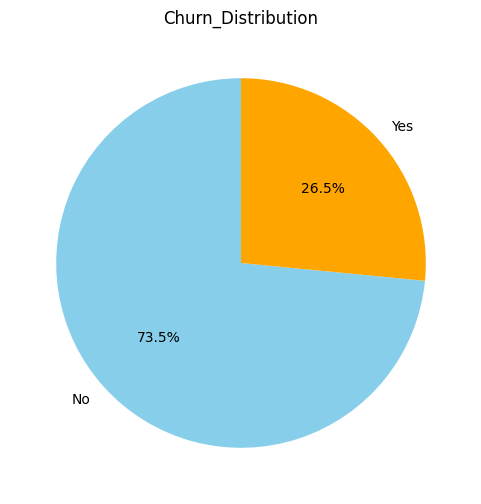

In [0]:
# Identifying the churn distribution between yes and no

# Count values
churn_count = df['Churn'].value_counts()

# Pie chart of churn value
plt.figure(figsize=(6,6))
plt.pie(churn_count, labels=churn_count.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Churn_Distribution')
plt.show()

In [0]:
# read some informstions about data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [0]:
# missing values
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Some necessary operations on variables:
1. Columns to Drop
These features are removed because they do not provide useful predictive information. They typically act as identifiers and only add noise to the dataset.

2. Target Variable
This represents the outcome the model is designed to predict. It serves as the reference point that guides how the algorithm learns patterns from the input features.

3. Boolean Columns
These features already exist in a binary numeric form, such as 0/1. Because of this, they require little to no preprocessing before being used in the model.

4. Columns to Convert to Boolean
These contain yes/no values stored as text and must be converted into binary form. Converting them ensures the model can interpret them correctly and uniformly.

5. Numerical Columns
These features contain measurable numeric values that often hold strong predictive importance. They may require scaling to keep their ranges consistent across the dataset.

6. Categorical Columns
These features contain text-based categories representing qualitative characteristics. They need to be encoded into numerical values so machine-learning algorithms can process them.

In [0]:
# 1 drop useless columns
df = df.drop(columns="customerID",axis=1)
df.shape

(7043, 20)

In [0]:
# there is other type of missing values
tenure_zero = (df['tenure'] == 0).sum()
print(tenure_zero)


11


In [0]:
# drop values where tenure is zero
df = df.drop(df[df['tenure'] == 0].index)
print((df['tenure'] == 0).sum())

0


In [0]:
# describe numerical columns
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208
std,0.368844,24.545260,30.085974
min,0.000000,1.000000,18.250000
25%,0.000000,9.000000,35.587500
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.862500
max,1.000000,72.000000,118.750000


We noticed the absence of total charges and this is because the column has not numerical type

In [0]:
# Let's correct the column of total charges
# convert to numeric values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.fillna(df["TotalCharges"].mean())
df['TotalCharges'].isna().sum()


np.int64(0)

In [0]:
# check duplicated values
(df.duplicated()).sum()

np.int64(22)

In [0]:
# drop duplicated values
df.drop_duplicates(inplace=True)
(df.duplicated()).sum()

np.int64(0)

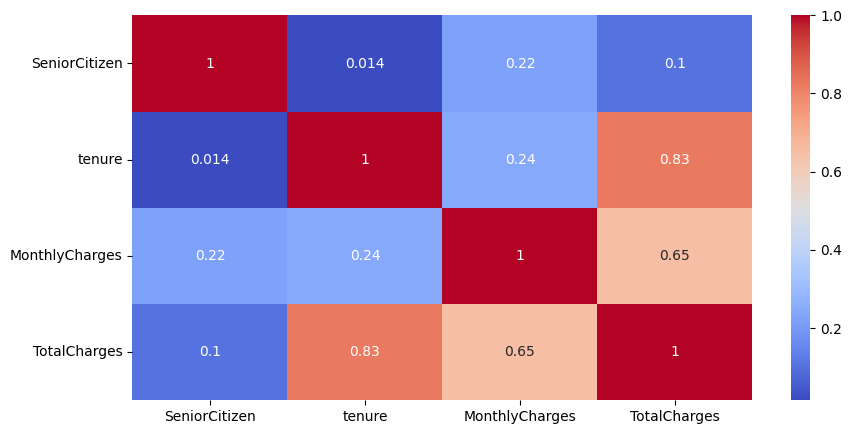

In [0]:
# corroleation between columns
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

Data Visualization

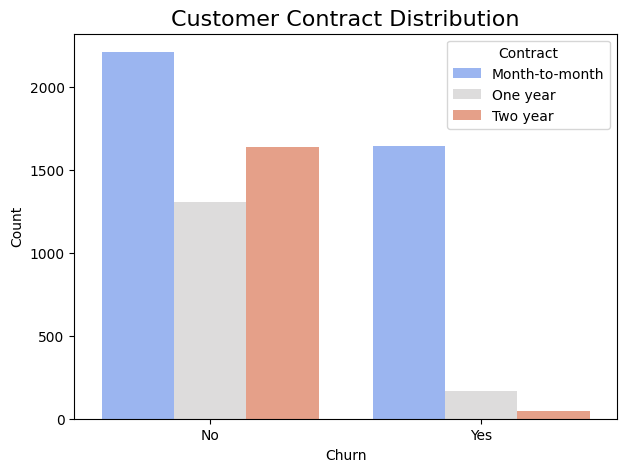

In [0]:
# Let's understand the churn distribution based on the contract type

# Set the figure size
plt.figure(figsize=(7, 5))

# Draw histogram with bars colored by 'Contract' type
sns.countplot(data=df,x="Churn", hue="Contract", palette="coolwarm"  )


# Add axis labels and title
plt.xlabel("Churn")
plt.ylabel("Count")
plt.title("Customer Contract Distribution", fontsize=16)
plt.legend(title="Contract")  # Legend title

# Display the plot
plt.show()


In [0]:
print(churn_gender)


gender
Female    934
Male      923
Name: Churn, dtype: int64


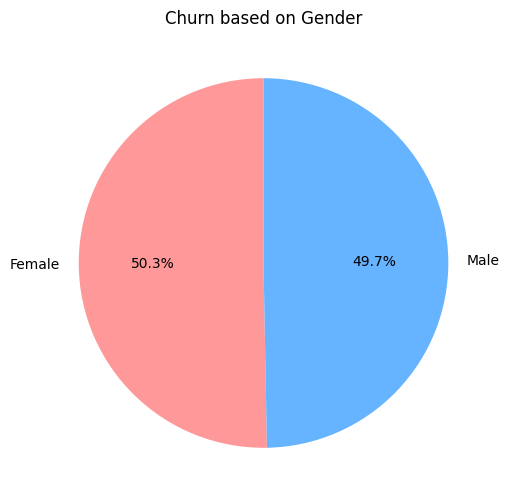

In [0]:
# understand churn based on gender
churn_gender = df[df["Churn"]=="Yes"].groupby("gender")["Churn"].count()

#  Pie chart
plt.figure(figsize=(6,6))
plt.pie(churn_gender, labels=churn_gender.index, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title("Churn based on Gender")
plt.show()



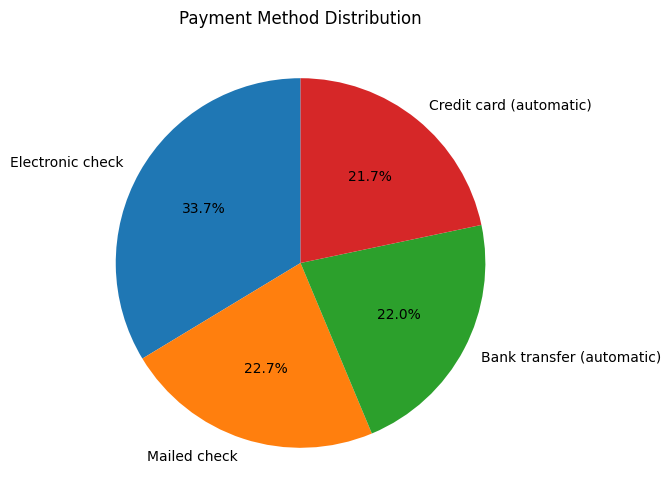

In [0]:
# comparing several types of payments
counts = df['PaymentMethod'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    counts.values,
    labels=counts.index,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Payment Method Distribution")
plt.show()


In [0]:

# People with dependents are less likely to leave compared to those without dependents
fig = px.histogram(
    data_frame=df,
    x="Churn",
    color="Dependents",   # تلوين حسب الفئات تلقائيًا
    barmode="group",
    width=700,
    height=500,
    title = "Dependents distribution"
    
)
fig.show()


People with dependents are less likely to leave compared to those without dependents

In [0]:
# make plot for tenure
churned = df[df['Churn'] == 'Yes']
not_churned = df[df['Churn'] == 'No']

# Plotting
plt.figure(figsize=(10, 6))
plt.hist([churned['tenure'], not_churned['tenure']], bins=10, color=['red', 'blue'], label=['Yes', 'No'])
plt.title(' Tenure by Churn')
plt.xlabel('Tenure')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Add text on top of bars
for rect in plt.gca().patches:
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width() / 2, height, height, ha='center', va='bottom')

In [0]:
import plotly.express as px
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="SeniorCitizen", barmode="group", title="<b>Chrun distribution w.r.t. Senior Citizen</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()


In [0]:
color_map = {"Yes": '#00CC96', "No": '#B6E880'}
fig = px.histogram(df, x="Churn", color="PhoneService", title="<b>Chrun distribution w.r.t. Phone Service</b>", color_discrete_map=color_map)
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [0]:
import seaborn as sns
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'No') ],
                color="Gold", shade = True);
ax = sns.kdeplot(df.TotalCharges[(df["Churn"] == 'Yes') ],
                ax =ax, color="Green", shade= True);
ax.legend(["Not Chu0rn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Total Charges');
ax.set_title('Distribution of total charges by churn');

In [0]:
fig = px.box(df, x='Churn', y = 'tenure')

# Update yaxis properties
fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
# Update xaxis properties
fig.update_xaxes(title_text='Churn', row=1, col=1)

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

In [0]:
# convert all columns to numerical data
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series
df = df.apply(lambda x: object_to_int(x))
df.head()

In [0]:
# corrolation
df.corr()['Churn'].sort_values(ascending = False)


In [0]:
# split data

X = df.drop(columns = ['Churn'])
y = df['Churn'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)

In [0]:
# make numeric values in the same scale 
def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].astype('float64')),
                       columns=num_cols)
for feat in numerical_cols: distplot(feat, df_std, color='c')

In [0]:
# KNeighborsClassifier model
knn_model = KNeighborsClassifier(n_neighbors = 11) 
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)
print(classification_report(y_test, predicted_y))


In [0]:
# svc model
svc_model = SVC(random_state = 1)
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy is :",accuracy_svc)
print(classification_report(y_test, predict_y))


In [0]:
# RandomForestClassifier model
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

In [0]:
#  heatmap
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.show()

In [0]:
# roc curve
# PLOTTING ROC CURVE FOR XGBOOST PRO
fpr_pro, tpr_pro, _ = roc_curve(y_test, y_proba_pro)
auc_pro = roc_auc_score(y_test, y_proba_pro)

plt.figure(figsize=(7,6))
plt.plot(fpr_pro, tpr_pro, label=f"XGBoost PRO (AUC={auc_pro:.3f})", linewidth=2)
plt.plot([0,1], [0,1], 'k--', label="Azar")

plt.title("Curva ROC — XGBoost PRO (Optimizado)")
plt.xlabel("1 - Especificidad (FPR)")
plt.ylabel("Sensibilidad (TPR)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [0]:
  pipeline = Pipeline([
        ('scaler', MinMaxScaler()),  # Feature Scaling
        ('model', model)
    ])

    # Hyperparameter tuning using GridSearchCV
    if param_grid:
        grid_search = GridSearchCV(pipeline, param_grid, cv=2)
        grid_search.fit(X_train, y_train)
        pipeline = grid_search.best_estimator_

    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = pipeline.predict(X_test)

    # Calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)

    # Append model name and accuracy to the list
    model_scores.append({'Model': name, 'Accuracy': accuracy})

    # Convert the list to a DataFrame
    scores_df = pd.DataFrame(model_scores)
    # Print the performance metrics
    print("Model:", name)
    print("Test Accuracy:", accuracy.round(3),"%")
    print()

In [0]:
## define the grid search for pipeline hp tuning
search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# search = RandomizedSearchCV(
#     estimator=pipeline,
#     param_distributions=param_grid, # Note: param_grid works for RandomizedSearch too
#     n_iter=15,                      # Train only 15 random combinations instead of all 24
#     scoring='f1_macro',
#     cv=3,                           # Reduce folds from 5 to 3 for speed
#     n_jobs=-1,
#     verbose=2,
#     random_state=42
# )

In [0]:
##  Save Model for Production

# Save the best estimator (this includes preprocessing + selection + model)
model_filename = 'telco_churn_pipeline.pkl'
joblib.dump(best_model, model_filename)

print(f"Model saved to {model_filename}")

In [0]:
# =======================================
# 7️⃣ Model Explainability
# =======================================
import shap
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Example dataset
X_train = pd.DataFrame({
    'MonthlyCharges': [20, 50, 70, 90],
    'Tenure': [1, 12, 24, 36]
})
y_train = [0, 1, 0, 1]

# Train Random Forest
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Explain the model predictions using SHAP
explainer = shap.TreeExplainer(model_rf)
shap_values = explainer.shap_values(X_train)

# Summary plot to show feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [0]:
# =======================================
# 8️⃣ Model Deployment (API)
# =======================================
from flask import Flask, request, jsonify
import pickle
import numpy as np

# Load trained model
model_rf = pickle.load(open('model_rf.pkl', 'rb'))

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Receive JSON input
    data = request.get_json()
    features = np.array(data['features']).reshape(1, -1)
    
    # Make prediction
    prediction = model_rf.predict(features)
    
    # Return JSON response
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)


In [0]:
# =======================================
# 9️⃣ User Interface / Dashboard (Optional)
# =======================================
import streamlit as st
import pickle
import numpy as np

# Load model
model_rf = pickle.load(open('model_rf.pkl', 'rb'))

st.title("Churn Prediction Dashboard")

# User input
monthly_charges = st.number_input("Monthly Charges", min_value=0)
tenure = st.number_input("Tenure (months)", min_value=0)

# Prediction button
if st.button("Predict"):
    features = np.array([monthly_charges, tenure]).reshape(1, -1)
    prediction = model_rf.predict(features)
    st.write("Prediction:", "Churn" if prediction[0]==1 else "No Churn")


In [0]:
# =======================================
# 1️⃣ Project Setup & Data Collection
# =======================================

# =======================================
# 2️⃣ Exploratory Data Analysis (EDA)
# =======================================

# =======================================
# 3️⃣ Data Cleaning & Preprocessing
# =======================================

# =======================================
# 4️⃣ Feature Engineering
# =======================================

# =======================================
# 5️⃣ Model Building & Training
# =======================================

# =======================================
# 6️⃣ Model Evaluation & Business Analysis
# =======================================

# =======================================
# 7️⃣ Model Explainability
# =======================================

# =======================================
# 8️⃣ Model Deployment (API)
# =======================================

# =======================================
# 9️⃣ User Interface / Dashboard (Optional)
# =======================================

# =======================================
# 🔟 Portfolio & Documentation
# =======================================
